<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recommender-system-for-business-categories-of-Yelp-businesses.-Uses-reviews" data-toc-modified-id="Recommender-system-for-business-categories-of-Yelp-businesses.-Uses-reviews-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recommender system for business categories of Yelp businesses. Uses reviews</a></span></li><li><span><a href="#ETL-(Extract,-Transform,-Load)" data-toc-modified-id="ETL-(Extract,-Transform,-Load)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ETL (Extract, Transform, Load)</a></span><ul class="toc-item"><li><span><a href="#Review-data" data-toc-modified-id="Review-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Review data</a></span></li><li><span><a href="#Merge-with-Business-Categories" data-toc-modified-id="Merge-with-Business-Categories-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Merge with Business Categories</a></span></li></ul></li><li><span><a href="#Recommender-System" data-toc-modified-id="Recommender-System-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recommender System</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Generate-recommendations" data-toc-modified-id="Generate-recommendations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate recommendations</a></span></li><li><span><a href="#Link-to-reviews-to-validate-quality-of-recommendations" data-toc-modified-id="Link-to-reviews-to-validate-quality-of-recommendations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Link to reviews to validate quality of recommendations</a></span></li></ul></li></ul></div>

# Recommender system for business categories of Yelp businesses. Uses reviews

In [1]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daviderickson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ETL (Extract, Transform, Load)

## Review data

In [2]:
def load_reviews(size='small'): 
    if size == 'small':
        filename = r'../../data/small-review.json'
    elif size == 'intermediate':
        filename = r'../../data/intermediate-review.json'
    elif size == 'full':
        filename = r'../../data/review.json'
    new_list = []
    for line in open(filename):
       new_list.append(json.loads(line))
    return pd.DataFrame.from_records(new_list)

dfreviews = load_reviews(size='intermediate')

In [3]:
def review_to_wordlist(string, remove_stopwords=False):
    string = re.sub("[^a-zA-Z]", " ", string) # keep only letters. more complex model possible later
    words =  string.lower().split() # make everything lowercase. split into words
    if remove_stopwords:
        stops = set(stopwords.words('english')) # create a fast lookup for stopwords
        words = [w for w in words if not w in stops] # remove stopwords
    return( words) # return a list of words
    


In [4]:
# Word2Vec expects single sentences, each one as a list of words

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [5]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences")
for review in dfreviews["text"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences


In [6]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2020-01-22 21:21:25,179 : INFO : 'pattern' package not found; tag filters are not available for English
2020-01-22 21:21:25,192 : INFO : collecting all words and their counts
2020-01-22 21:21:25,194 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-22 21:21:25,237 : INFO : PROGRESS: at sentence #10000, processed 140966 words, keeping 9537 word types
2020-01-22 21:21:25,271 : INFO : PROGRESS: at sentence #20000, processed 279509 words, keeping 13297 word types
2020-01-22 21:21:25,301 : INFO : PROGRESS: at sentence #30000, processed 416170 words, keeping 16108 word types
2020-01-22 21:21:25,334 : INFO : PROGRESS: at sentence #40000, processed 552466 words, keeping 18464 word types
2020-01-22 21:21:25,363 : INFO : PROGRESS: at sentence #50000, processed 690423 words, keeping 20660 word types
2020-01-22 21:21:25,393 : INFO : PROGRESS: at sentence #60000, processed 829572 words, keeping 22414 word types


Training model...


2020-01-22 21:21:25,425 : INFO : PROGRESS: at sentence #70000, processed 967451 words, keeping 24105 word types
2020-01-22 21:21:25,460 : INFO : PROGRESS: at sentence #80000, processed 1106355 words, keeping 25709 word types
2020-01-22 21:21:25,493 : INFO : PROGRESS: at sentence #90000, processed 1245199 words, keeping 27118 word types
2020-01-22 21:21:25,528 : INFO : PROGRESS: at sentence #100000, processed 1385155 words, keeping 28435 word types
2020-01-22 21:21:25,559 : INFO : PROGRESS: at sentence #110000, processed 1522186 words, keeping 29854 word types
2020-01-22 21:21:25,588 : INFO : PROGRESS: at sentence #120000, processed 1658125 words, keeping 31115 word types
2020-01-22 21:21:25,622 : INFO : PROGRESS: at sentence #130000, processed 1797345 words, keeping 32404 word types
2020-01-22 21:21:25,650 : INFO : PROGRESS: at sentence #140000, processed 1935475 words, keeping 33568 word types
2020-01-22 21:21:25,683 : INFO : PROGRESS: at sentence #150000, processed 2074816 words, kee

2020-01-22 21:21:27,764 : INFO : PROGRESS: at sentence #790000, processed 10933711 words, keeping 73548 word types
2020-01-22 21:21:27,774 : INFO : collected 73717 word types from a corpus of 10978770 raw words and 793093 sentences
2020-01-22 21:21:27,774 : INFO : Loading a fresh vocabulary
2020-01-22 21:21:27,815 : INFO : effective_min_count=40 retains 8557 unique words (11% of original 73717, drops 65160)
2020-01-22 21:21:27,816 : INFO : effective_min_count=40 leaves 10670794 word corpus (97% of original 10978770, drops 307976)
2020-01-22 21:21:27,845 : INFO : deleting the raw counts dictionary of 73717 items
2020-01-22 21:21:27,850 : INFO : sample=0.001 downsamples 57 most-common words
2020-01-22 21:21:27,852 : INFO : downsampling leaves estimated 7804072 word corpus (73.1% of prior 10670794)
2020-01-22 21:21:27,879 : INFO : estimated required memory for 8557 words and 300 dimensions: 24815300 bytes
2020-01-22 21:21:27,880 : INFO : resetting layer weights
2020-01-22 21:21:28,002 : I

2020-01-22 21:22:12,167 : INFO : training on a 54893850 raw words (39021049 effective words) took 44.2s, 883550 effective words/s
2020-01-22 21:22:12,168 : INFO : precomputing L2-norms of word weight vectors


In [7]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # WV.Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = int(0.)
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1
    return reviewFeatureVecs

In [8]:
# ****************************************************************
# Calculate average feature vectors
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_reviews = []
for review in dfreviews["text"]:
    clean_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

reviewDataVecs = getAvgFeatureVecs( clean_reviews, model, num_features )

Review 0 of 100000


/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 100000
Review 2000 of 100000
Review 3000 of 100000
Review 4000 of 100000
Review 5000 of 100000
Review 6000 of 100000
Review 7000 of 100000
Review 8000 of 100000


/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Review 9000 of 100000
Review 10000 of 100000
Review 11000 of 100000
Review 12000 of 100000
Review 13000 of 100000
Review 14000 of 100000
Review 15000 of 100000
Review 16000 of 100000
Review 17000 of 100000
Review 18000 of 100000
Review 19000 of 100000
Review 20000 of 100000
Review 21000 of 100000
Review 22000 of 100000
Review 23000 of 100000
Review 24000 of 100000
Review 25000 of 100000
Review 26000 of 100000
Review 27000 of 100000
Review 28000 of 100000
Review 29000 of 100000
Review 30000 of 100000
Review 31000 of 100000
Review 32000 of 100000
Review 33000 of 100000
Review 34000 of 100000
Review 35000 of 100000
Review 36000 of 100000
Review 37000 of 100000
Review 38000 of 100000
Review 39000 of 100000
Review 40000 of 100000
Review 41000 of 100000
Review 42000 of 100000
Review 43000 of 100000
Review 44000 of 100000
Review 45000 of 100000
Review 46000 of 100000
Review 47000 of 100000
Review 48000 of 100000
Review 49000 of 100000
Review 50000 of 100000
Review 51000 of 100000
Review 52000

In [9]:
# Create df 
all_features_labels = ['w2v{}'.format(idx) for idx in range(reviewDataVecs.shape[1])]
all_features_df = pd.DataFrame(data=reviewDataVecs, columns=all_features_labels)

all_features_df['business_id'] = dfreviews['business_id']
# Convert all but business_id to numerical
# business_ids = all_features_df['business_id']
# all_features_df = all_features_df.iloc[:,:-1].astype('float64')
# all_features_df['business_id'] = business_ids
# del business_ids

# Group by business_id
all_features_business = all_features_df.groupby(by='business_id').mean()

## Merge with Business Categories

In [10]:
def load_business_df(): 
    filename = r'../../data/business.json'
    new_list = []
    for line in open(filename):
       new_list.append(json.loads(line))
    return pd.DataFrame.from_records(new_list)

dfbusiness = load_business_df()

In [11]:
# Add business categories to features df
business_cols = ['business_id', 'categories']
all_features_business = all_features_business.merge(dfbusiness[business_cols], how='left', on='business_id') 

In [12]:
def stringDFColToBinaryCols(df, series_name):
    # Create list of all categories
    all_cats = []
    for string in df[series_name]:
        string = str(string)
        cats = string.strip().replace(' ', '').split(',')
        for cat in cats:
            if cat not in all_cats:
                all_cats.append(cat)
    # Make binary for each cat for each row
    for cat in all_cats:
        df[cat] = df[series_name].str.strip().str.replace(' ', '').str.contains(cat)
        # This technique will have some problems. 'Golf' may appear in non-Golf categories (ie 'Disc Golf')
        # Can be fixed with regular expressions: ',Golf,' OR 'BOF Golf,' OR ',Golf EOF'
    
    return df, all_cats

# Business categories are encoded as a string. Convert that to binary columns for label prediction
all_features_business, all_cats = stringDFColToBinaryCols(all_features_business, 'categories')

# It will be helpful to have a Series object later
all_cats_ser = pd.Series(data=all_cats)

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


In [13]:
# Clean

# Remove rows with NaNs
print('Before: ', len(all_features_business))
all_features_business = all_features_business.dropna(axis=0)
print('After:  ', len(all_features_business))

Before:  13943
After:   13922


# Recommender System

## Train

In [14]:
# Prepare the data for the model

# First, shuffle the dataframe 
# and reset the index. (Makes for easier handling of train/test splitting later)
all_features_business = all_features_business.sample(frac=1).reset_index(drop=True)

# Create final y and x 
y_df = all_features_business[all_cats]
x_cols = [ele for ele in all_features_business.columns if ele not in all_cats+['categories', 'business_id']]
x_df = all_features_business[x_cols]

# Numpy arrays for sklearn
x = x_df.values
y = y_df.values

# Classifier wants 1/0, not T/F
y = y.astype(int)

# Split into Train/Test sets
def splitSets(x, y, test_size=0.2):
    test_size_absolute = np.int(test_size * len(x))
    X_test, X_train = x[:test_size_absolute,:], x[test_size_absolute:,:]
    y_test, y_train = y[:test_size_absolute,:], y[test_size_absolute:,:]
    return X_train, X_test, y_train, y_test
    
test_size = 0.2
X_train, X_test, y_train, y_test = splitSets(x, y, test_size=test_size)

In [15]:
# Multilabel Classification
# RandomForestClassifier supports multilabel classification

# Most other classifiers will require use of 
    # sklearn.multioutput.MultiOutputClassifier to run a separate classifier model for each targe
    
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Generate recommendations

In [17]:
y_predict = rfc.predict(X_test)

In [18]:
# Filter for recommendations. (Not presently listed) AND (predicted by algorithm)
reccs_binary = (y_test == 0) & (y_predict == 1)

# Create recommendations dataframe
all_cats_true = []
all_cats_recc = []
for biz in range(len(y_test)):
    cats_true = ', '.join(list(all_cats_ser[y_test[biz,:]==1]))
    all_cats_true.append(cats_true)
    
    cats_recc = ', '.join(list(all_cats_ser[reccs_binary[biz,:]==True]))
    all_cats_recc.append(cats_recc)
reccs_df = pd.DataFrame(data=all_cats_true, columns=['Labeled Categories'])
reccs_df['Recommended'] = all_cats_recc


In [23]:
# Look at the recommendations
pd.options.display.max_rows=999
pd.options.display.max_columns=999
pd.options.display.max_colwidth=999
reccs_df[reccs_df['Recommended']!=''].sort_values(by='Recommended')

,Labeled Categories,Recommended,business_id
1116,"Arts&Entertainment, Stadiums&Arenas","ActiveLife, Parks",u9ol5WeLInFRK-PTKUx6gw
1797,"RealEstate, HomeServices, PropertyManagement, HomeownerAssociation",Apartments,ufeyCADuHbRzso0KBoUQIQ
613,"Automotive, AutoGlassServices, Wheel&RimRepair, Tires, CarWash",AutoRepair,qNChnVaoWDS-RFd9NDBPEA
737,"Automotive, CarStereoInstallation",AutoRepair,mpMS735pEOOzjy_UzTyqrA
2064,"Automotive, CarDealers",AutoRepair,z_8sfyOS8yyFiihSvi6V6Q
1249,"Automotive, BodyShops, Towing",AutoRepair,ML2t7AfdnHNf9df6CT27FA
2296,"LocalServices, HomeServices, WaterPurificationServices, WaterDelivery",Automotive,Geps0j_0HuOilQX8Xmmhvg
1807,"LocalServices, Shopping, ITServices&ComputerRepair, MobilePhones, MobilePhoneRepair",Automotive,1wJckBZ43wD3Y8SEm92c-Q
2524,"LocalServices, HomeServices, HomeCleaning, CarpetCleaning, Heating&AirConditioning/HVAC, Carpeting, AirDuctCleaning, Tiling",Automotive,XSH26iypc1QjC7GXEKHhEw
1704,"LocalServices, Shopping, ActiveLife, SportingGoods, Bikes, BikeRepair/Maintenance, BikeRentals",Automotive,BoPBd9Q32bCuQ4Si9baM4g


In [39]:
def uniqueRecsDF(reccs_df=reccs_df):
    some_cats = []
    unique_recs_df = pd.DataFrame(columns=reccs_df.columns)
    for index, row in reccs_df.iterrows():
        if row['Recommended'] not in some_cats: 
            some_cats.append(row['Recommended'])
            unique_recs_df = unique_recs_df.append(row)
    return unique_recs_df

unique_recs_df = uniqueRecsDF(reccs_df)
unique_recs_df

,Labeled Categories,Recommended,business_id
0,"FinancialServices, Insurance",,UCdRR46BUOiPZhf0ChrXDQ
2,ProfessionalServices,Shopping,Ma6tSm6kCFHug7RLL7A_VQ
8,"Food, SpecialtyFood",Restaurants,l6rxaCNZRx9JkOkLkb8VPw
10,"PetGroomers, Veterinarians, PetSitting, Pets, PetServices, PetBoarding, PetStores",Health&Medical,0aPo55kIjRGj-mKd5q7FwQ
60,"Restaurants, Thai",Chinese,UGG8EIfEfAIbyGhgLIX7Mw
66,"Restaurants, EventPlanning&Services, Caterers, Indian",Food,3WFMeB2eYce2E1iLZgAg2A
88,"Restaurants, Italian","Nightlife, Bars",pHpOuNf02eMyhdCnvMQGhg
122,"Beauty&Spas, Barbers",HairSalons,jIHXTUXWaHdPg-DXFbq5XQ
146,"Food, Breweries","Nightlife, Restaurants, Bars",QjbnYglxVLDrS64t4ElJXQ
167,"Restaurants, Sandwiches, Italian, Seafood, Steakhouses",Bars,BvYU3jvGd0TJ7IyZdfiN2Q


In [54]:
# Most common Reccommendation?

reccs_df.groupby(by='Recommended')['Recommended'].count()
most_recommended_df = reccs_df.groupby(by='Recommended')['Recommended'].count().to_frame()
most_recommended_df['frequency'] = most_recommended_df['Recommended'] / most_recommended_df['Recommended'].sum()
most_recommended_df

,Recommended,frequency
Recommended,,
,2484,0.892241
"ActiveLife, Parks",1,0.000359
Apartments,1,0.000359
AutoRepair,4,0.001437
Automotive,7,0.002514
Bakeries,2,0.000718
Bars,5,0.001796
Beauty&Spas,3,0.001078
Burgers,1,0.000359


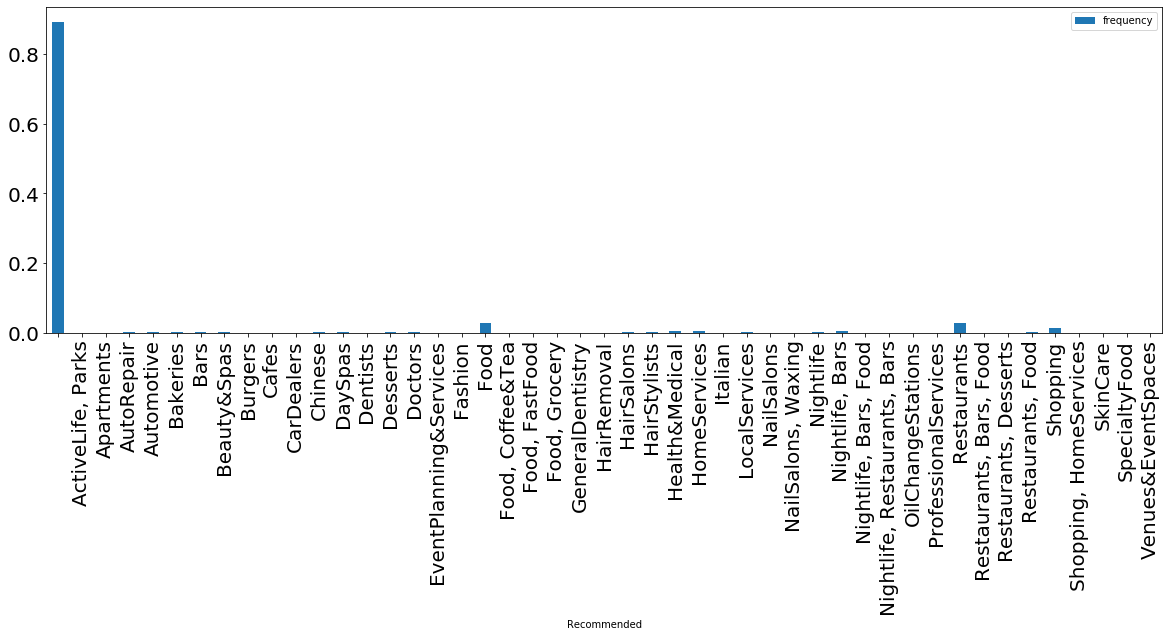

In [104]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
most_recommended_df.plot.bar(y='frequency', ax=ax)
ax.tick_params(labelsize=20)

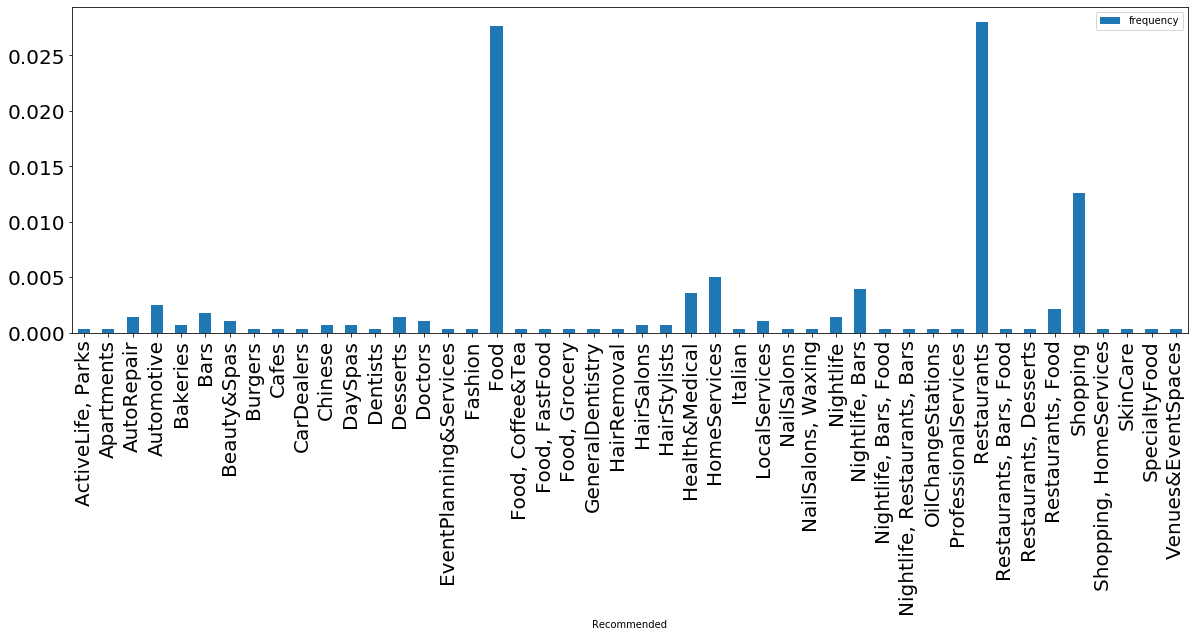

In [97]:
binary_recommendation_made = most_recommended_df.index != ''
fig, ax = plt.subplots(figsize=(20, 6))
most_recommended_df[binary_recommendation_made].plot.bar(y='frequency', ax=ax)
ax.tick_params(labelsize=20)

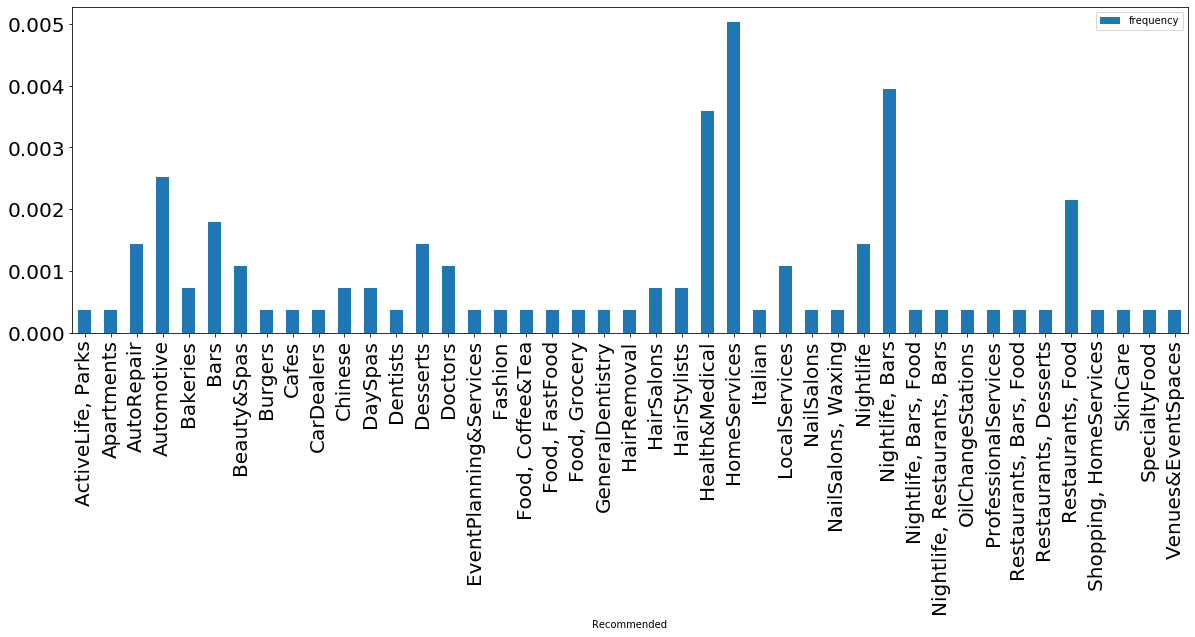

In [103]:
exemptions = ['', 'Food', 'Restaurants', 'Shopping', 'Restaurants,Food']
binar_recommendation_made = most_recommended_df.index != ''
for exem in exemptions:
    binary_recommendation_made = binary_recommendation_made & (most_recommended_df.index != exem)

fig, ax = plt.subplots(figsize=(20, 6))
most_recommended_df[binary_recommendation_made].plot.bar(y='frequency', ax=ax)
ax.tick_params(labelsize=20)

## Link to reviews to validate quality of recommendations

In [20]:
# Include business_id so that we can use it as a key to find reviews for the business
reccs_df['business_id'] = all_features_business['business_id'].iloc[:len(reccs_df)]


In [21]:

pd.set_option('display.max_colwidth',2000)
def businessReviews(dfreviews=dfreviews, biz_id='KN0gPRzDvA6uVYims2KA0w'):
    return dfreviews[dfreviews['business_id']=='KN0gPRzDvA6uVYims2KA0w']['text']

businessReviews(dfreviews, biz_id='KN0gPRzDvA6uVYims2KA0w')

6680                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         This cute little place is really nearby my house and they have a lot of nice comfort food here.  I've only ever gone here for brunch and their portions are definitely big enough to share.  You can add little things (ie: